# Food Delivery Optimization in Milan

## Introduction

In this project we will find the best placements for a number, in this case 10, of food couriers in Milan to optimize the delivery service with faster and better deliveries and also improve working conditions of couriers who will have to travel less distance.  

## Business Problem

In Milan there are many food delivery services and many more restaurants, so the optimal organization beetween these two fundamental components of the food business is essential to create an efficient and profitable system.
The target audience intersted in this project are the food delivery companies who work in the area of Milan because finding the optimal location in which the couriers will wait the next order is useful to reduce the time necessary to reach the restaurant, so the meal will be better, the client will wait less and the courier will travel less distance.

## Data Description

Using the Foursquare API we will retrieve the data of the restaurants and food services in the area of Milan, which has a location of 45°28'01" N and 09°11'24" E. For each activity we will retrieve name, position and type of cuisine. Through a KK-means algorithm with 10 point we will define the locations which minimize the distance beetween the couriers and the restaurants and finally we will analyze the composition of each cluster of restaurants by their cousine.    

In [37]:
# Import the necessary libraries
import numpy as np
import requests
import json

In [112]:
import pandas as pd
from pandas.io.json import json_normalize

In [39]:
# Define the Foursquare credentials
CLIENT_ID = 'TS4O02SW4CRHYCFOSATBLREBBH5QB3FIZD4IEDUPFZFUOLUV' # your Foursquare ID
CLIENT_SECRET = 'NGJ0VOEPCK4LCVQMXDUYRNSO2BO0ZW0OHQGV1TWRQQU4K4KY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TS4O02SW4CRHYCFOSATBLREBBH5QB3FIZD4IEDUPFZFUOLUV
CLIENT_SECRET:NGJ0VOEPCK4LCVQMXDUYRNSO2BO0ZW0OHQGV1TWRQQU4K4KY


In [40]:
milan_lat = 45.4669444 # Milan centre latitude
milan_lon = 9.19 # Milan centre longitude
lat_dev=0.0225225 # Correspond approximately to a 2.5 km movement in latitude from the city centre 
lon_dev=0.0316456 # Correspond approximately to a 2.5 km movement in longitude from the city centre

# The coordinates below corresponds to a clockwise rotation in a multiple for loop of the coordinate points starting from the left point, 
# except the first element which is the milan centre
latitudes=[milan_lat, milan_lat+lat_dev, milan_lat-lat_dev]
longitudes=[milan_lon, milan_lon-lon_dev, milan_lon+lon_dev]


Now we will generate the Foursquare urls to obtain the necessary data. We will apply the research on 9 centers positioned in a 3x3 grid to maximize the number of venues obtained from the requests, which are at most 100.

In [41]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius
categoryId = '4d4b7105d754a06374d81259' #Food category
urls=[0]*9
i=0

# for cycle to obtain more results from Foursquare API (max limit 100 results)
for latitude in latitudes:
    for longitude in longitudes:

        # create URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT, 
            categoryId)
        urls[i]=url # save URL
        i=i+1

urls

['https://api.foursquare.com/v2/venues/explore?&client_id=TS4O02SW4CRHYCFOSATBLREBBH5QB3FIZD4IEDUPFZFUOLUV&client_secret=NGJ0VOEPCK4LCVQMXDUYRNSO2BO0ZW0OHQGV1TWRQQU4K4KY&v=20180605&ll=45.4669444,9.19&radius=3000&limit=100&categoryId=4d4b7105d754a06374d81259',
 'https://api.foursquare.com/v2/venues/explore?&client_id=TS4O02SW4CRHYCFOSATBLREBBH5QB3FIZD4IEDUPFZFUOLUV&client_secret=NGJ0VOEPCK4LCVQMXDUYRNSO2BO0ZW0OHQGV1TWRQQU4K4KY&v=20180605&ll=45.4669444,9.1583544&radius=3000&limit=100&categoryId=4d4b7105d754a06374d81259',
 'https://api.foursquare.com/v2/venues/explore?&client_id=TS4O02SW4CRHYCFOSATBLREBBH5QB3FIZD4IEDUPFZFUOLUV&client_secret=NGJ0VOEPCK4LCVQMXDUYRNSO2BO0ZW0OHQGV1TWRQQU4K4KY&v=20180605&ll=45.4669444,9.221645599999999&radius=3000&limit=100&categoryId=4d4b7105d754a06374d81259',
 'https://api.foursquare.com/v2/venues/explore?&client_id=TS4O02SW4CRHYCFOSATBLREBBH5QB3FIZD4IEDUPFZFUOLUV&client_secret=NGJ0VOEPCK4LCVQMXDUYRNSO2BO0ZW0OHQGV1TWRQQU4K4KY&v=20180605&ll=45.489466900000004

In [42]:
# Normalize and clean the results
for i in range(8):
    results = requests.get(urls[i]).json()
    if i==0:
        venues=json_normalize(results['response']['groups'][0]['items'])
    else:
        venues = pd.concat([venues, json_normalize(results['response']['groups'][0]['items'])])
   

C:\Users\danif\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.
C:\Users\danif\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [43]:
# function that extracts the category of the venue
def get_category_type(row):

    categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [44]:
# Add the category to the df and rearrange the columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues = venues.loc[:, filtered_columns]

categories=[]

for x in range(0, len(venues)):
    categories.append(get_category_type(venues.iloc[x]))

venues['venue.categories'] = categories
venues.columns = ['Name', 'Category', 'Latitude', 'Longitude']
print(venues)

                                    Name                  Category   Latitude  \
0                                  Luini                    Bakery  45.465707   
1                               Spontini               Pizza Place  45.465655   
2                       Langosteria Café                    Bistro  45.464760   
3                             La Veranda  Mediterranean Restaurant  45.469293   
4           Galleria Ristorante Pizzeria        Italian Restaurant  45.465881   
..                                   ...                       ...        ...   
95                  Zen Sushi Restaurant       Japanese Restaurant  45.459700   
96                          Nerino Dieci        Italian Restaurant  45.461091   
97                             Calafuria               Pizza Place  45.465140   
98                            Trapizzino            Sandwich Place  45.467483   
99  Zibo - Cuochi Itineranti, Campo Base                    Bistro  45.459180   

    Longitude  
0    9.1914

In [45]:
# Drop the duplicates
venues.drop_duplicates(['Name', 'Latitude', 'Longitude'], inplace=True)
venues

,Name,Category,Latitude,Longitude
0,Luini,Bakery,45.465707,9.191431
1,Spontini,Pizza Place,45.465655,9.191222
2,Langosteria Café,Bistro,45.464760,9.194899
3,La Veranda,Mediterranean Restaurant,45.469293,9.195544
4,Galleria Ristorante Pizzeria,Italian Restaurant,45.465881,9.190025
...,...,...,...,...
92,Ristorante Erba Brusca,Italian Restaurant,45.422867,9.167307
93,BA Asian Mood,Asian Restaurant,45.468122,9.151817
94,Cacio e Pepe,Italian Restaurant,45.452780,9.181500
98,Trapizzino,Sandwich Place,45.467483,9.154074


In [113]:
# Import folium to generate the map
import folium
print('Folium imported successfully.')

Folium imported successfully.


In [47]:
# create map of Milan using latitude and longitude values
map_milan = folium.Map(location=[milan_lat, milan_lon], zoom_start=12)

# add markers to map
for lat, lng, label in zip(venues['Latitude'], venues['Longitude'], venues['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

## Methodology Section

In this section we will start analyzing the data by dividing the venues in different clusters using a kk-means alghoritm:

In [48]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [49]:
#Initialize the starting k-means centers
init_centres = np.array([[milan_lat, milan_lon], [milan_lat, milan_lon], [milan_lat, milan_lon+lon_dev], 
                [milan_lat, milan_lon-lon_dev], [milan_lat+lat_dev, milan_lon], [milan_lat+lat_dev, milan_lon+lon_dev], 
                [milan_lat+lat_dev, milan_lon-lon_dev], [milan_lat-lat_dev, milan_lon], 
                [milan_lat-lat_dev, milan_lon+lon_dev], [milan_lat-lat_dev, milan_lon-lon_dev]])


In [50]:
#Transform the coordinates of the venues in np.array to feed in the kmeans
coordinates_array=venues[['Latitude','Longitude']].to_numpy()
coordinates_array

array([[45.46570727,  9.19143057],
       [45.46565532,  9.19122156],
       [45.46475951,  9.19489866],
       [45.46929305,  9.19554411],
       [45.46588067,  9.19002472],
       [45.462163  ,  9.185767  ],
       [45.46651401,  9.1832619 ],
       [45.46630906,  9.19551788],
       [45.47040337,  9.19236908],
       [45.46988   ,  9.1946    ],
       [45.46264   ,  9.183381  ],
       [45.47097444,  9.19295802],
       [45.46281643,  9.18902269],
       [45.46489747,  9.19189093],
       [45.46925804,  9.18545008],
       [45.46321507,  9.18966411],
       [45.47415225,  9.18344915],
       [45.46532006,  9.19006008],
       [45.46433731,  9.17930962],
       [45.46675106,  9.19539483],
       [45.46887653,  9.19912537],
       [45.46724   ,  9.18445   ],
       [45.46611897,  9.19662799],
       [45.47465125,  9.18335606],
       [45.47220711,  9.18704528],
       [45.4597    ,  9.18867   ],
       [45.46302917,  9.18796797],
       [45.4648749 ,  9.19174073],
       [45.45870448,

In [51]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init=(init_centres)).fit(coordinates_array)

# check cluster centers generated 
kmeans.cluster_centers_

C:\Users\danif\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


array([[45.46587841,  9.18654583],
       [45.48836989,  9.14574387],
       [45.47581492,  9.21333023],
       [45.45913787,  9.1474553 ],
       [45.48533063,  9.18794993],
       [45.4973531 ,  9.22418958],
       [45.48797821,  9.16924544],
       [45.44211356,  9.17820025],
       [45.45232501,  9.20593301],
       [45.45448221,  9.17204475]])

In [52]:
# add clustering labels
venues.insert(0, 'Cluster Labels', kmeans.labels_)

Now we will show the different clusters generated from the kmeans function:

In [115]:
# create map
map_clusters = folium.Map(location=[milan_lat, milan_lon], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add venues markers to the map
markers_colors = []
for lat, lon, cluster, venue in zip(venues['Latitude'], venues['Longitude'], venues['Cluster Labels'], venues['Name']):
    label = folium.Popup(str(venue) + ' - Courier Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

m_colors=['darkred', 'purple', 'darkblue', 'blue', 'lightblue', 'cadetblue', 'lightgreen', 'lightgray', 'orange', 'red']    

#Add cluster centers to the map
for i, coord in zip(range(10), kmeans.cluster_centers_):
    folium.Marker(
        location=coord,
        popup='Courier Base N.' + str(i+1),
        icon=folium.Icon(color=m_colors[i])
    ).add_to(map_clusters)
       
map_clusters

The k-means cluster algorithms permit to localize 10 different courier bases which maximize the distances between each other, but minimize the distances between the cluster centers and the venues. Each courier could be assigned a base location which will be used as a reference hub to wait for next order.  

Now we analize each cluster:

In [55]:
import matplotlib.pyplot as plt

In [56]:
# Count number of venues per cluster
ven_per_base = venues.groupby('Cluster Labels').count()
ven_per_base = ven_per_base[['Name']]
ven_per_base.columns = ['n_of_venues']
ven_per_base

,n_of_venues
Cluster Labels,
0,50
1,15
2,38
3,26
4,61
5,36
6,39
7,23
8,48


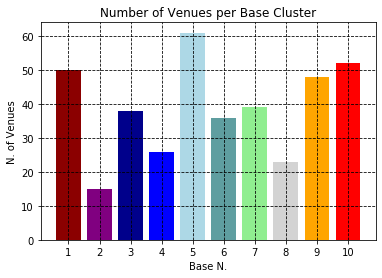

In [57]:
# Plot the results
plt.bar(ven_per_base.index+1, ven_per_base['n_of_venues'], color=m_colors)
plt.title('Number of Venues per Base Cluster')
plt.xlabel('Base N.')
plt.ylabel('N. of Venues')
plt.xticks(np.arange(10)+1)
plt.grid(color='black', linestyle='--', zorder=0.0)
plt.show()

The clusters have different numbers of venues: the base cluster number 2 has only 15 venues, instead the base number 5 is up to 61 venues. This difference is an important characteristic of each cluster because is an indicator of the number of orders that each base will receive. 

Now we calculate the mean distance from base to restaurant for each cluster:

In [58]:
# Function to calculate distances between cluster centers and venues
def calc_distance(row):
    
    coord=kmeans.cluster_centers_
    lat_km=111.0
    lon_km=79.0
    
    return np.sqrt(np.square((row['Latitude']-coord[row['Cluster Labels']][0])*lat_km) + 
                           np.square((row['Longitude']-coord[row['Cluster Labels']][1])*lon_km))

In [59]:
# Calculate distances and add to df
distances=venues.apply(calc_distance, axis=1)
venues['Distance[km]'] = distances
venues

,Cluster Labels,Name,Category,Latitude,Longitude,Distance[km]
0,0,Luini,Bakery,45.465707,9.191431,0.386361
1,0,Spontini,Pizza Place,45.465655,9.191222,0.370212
2,0,Langosteria Café,Bistro,45.464760,9.194899,0.671459
3,0,La Veranda,Mediterranean Restaurant,45.469293,9.195544,0.805598
4,0,Galleria Ristorante Pizzeria,Italian Restaurant,45.465881,9.190025,0.274832
...,...,...,...,...,...,...
92,7,Ristorante Erba Brusca,Italian Restaurant,45.422867,9.167307,2.303130
93,3,BA Asian Mood,Asian Restaurant,45.468122,9.151817,1.055037
94,9,Cacio e Pepe,Italian Restaurant,45.452780,9.181500,0.770491
98,3,Trapizzino,Sandwich Place,45.467483,9.154074,1.063692


In [60]:
# Calculate the mean distance between bases and resaturants for each cluster
cluster_mean = venues.groupby('Cluster Labels').mean()
cluster_mean.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
cluster_mean

,Distance[km]
Cluster Labels,
0,0.635069
1,0.971724
2,0.907215
3,1.102274
4,0.702900
5,1.215788
6,1.024709
7,0.831343
8,0.659472


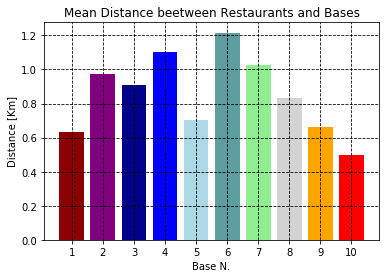

In [61]:
# Plot the results
plt.bar(cluster_mean.index+1, cluster_mean['Distance[km]'], color=m_colors)
plt.title('Mean Distance beetween Restaurants and Bases')
plt.xlabel('Base N.')
plt.ylabel('Distance [Km]')
plt.xticks(np.arange(10)+1)
plt.grid(color='black', linestyle='--', zorder=0.0)
plt.show()

Another important feature of each cluster is the mean distance between bases and venues because it is an index of how long it will take for the courier to reach the restaurant and of the length of the route. Clusters number 2, 4, 6 and 7 are the ones with the biggest mean distance. 

And finally we analize each cluster by their cousine:

In [64]:
# Function to count the ocurrence of venues categories which also groups the categories with less than 3 ocurrences 
# in other category
def count_cat_venues(i):

    cluster_venues = venues.loc[venues['Cluster Labels'] == i]
    clu_analysis = cluster_venues.groupby('Category').count()
    clu_analysis = clu_analysis[['Name']]
    clu_analysis.columns = ['N. of Venues']
    clu_analysis.reset_index(inplace=True)
    others = 0
    del_indexes = []

    for j in range(len(clu_analysis)):
        data = clu_analysis.iloc[j]
        if data['N. of Venues'] < 3:
            others = others+data['N. of Venues']
            del_indexes.append(j)

    clu_analysis.drop(del_indexes, inplace=True)
    new_element = pd.DataFrame(data={'Category':'Others', 'N. of Venues':[others]})
    clu_analysis = clu_analysis.append(new_element)
    clu_analysis.reset_index(drop=True, inplace=True)

    return clu_analysis

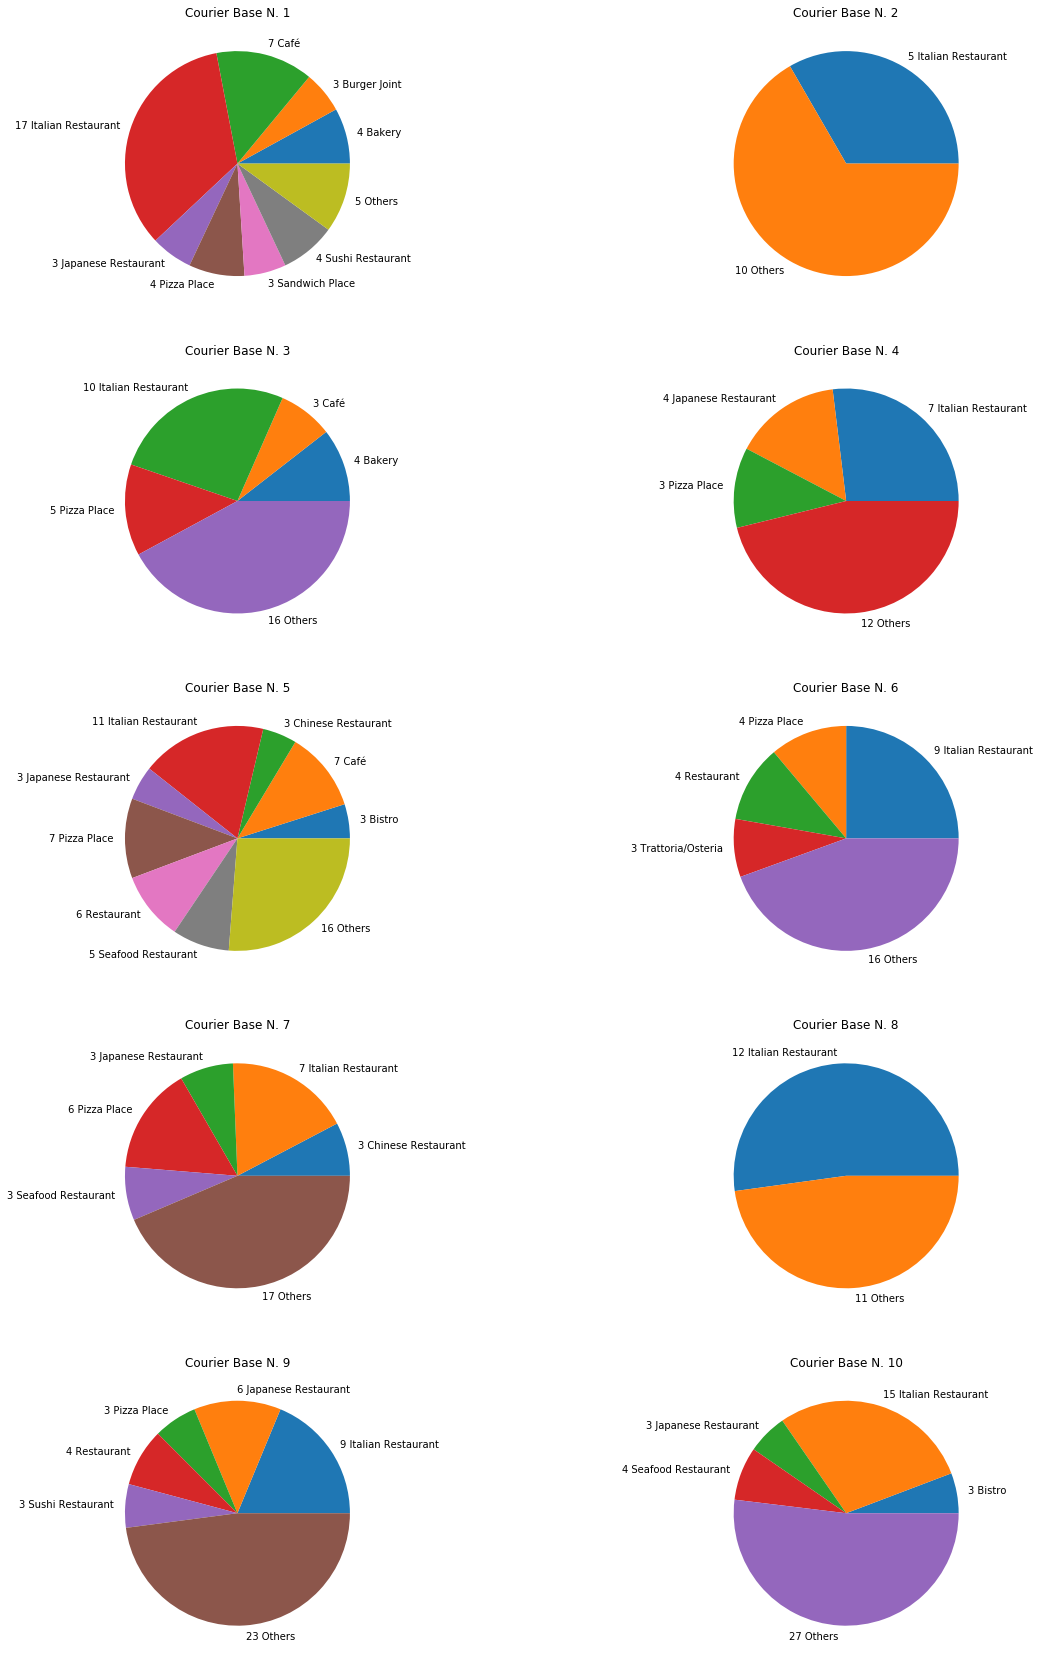

In [111]:
# Apply the function for each cluster and generate pie charts
nrow = 5
ncol = 2

fig, axes = plt.subplots(nrow, ncol)
plt.rcParams['figure.figsize'] = [20, 30]

count=0

for row in axes:
    for col in row:
        data = count_cat_venues(count)
        col.pie(data['N. of Venues'], labels=data['N. of Venues'].astype('string')+' '+data['Category'])
        col.set_title('Courier Base N. {}'.format(count+1))
        count=count+1

The pie charts shows that there are basically two types of clusters: the ones with a predominant type of cuisine, as bases 2 and 8 with "Italian Restaurants", and the ones with a very diverse set of important categories. 

## Discussion

The results of the clusterization showed that is possible to locate an arbitrary number of bases, in this case 10, to optimize the connection between food couriers and restaurants. The number of venues per cluster varies for each base, so is a good suggestion to assign more couriers to cluster centers with more venues. 

At the same time the graph of the mean distance between bases and venues per cluster shows that in general the cluster with less venues have a greater mean distance, for example clusters 2, 4 and 8. 
The most critique situations are clusters 3 and 7 which have both a large number of venues and a considerable mean distance, so it is possible that they are the bases that need more staff.

The pie charts could be used to optimize the gear of the couriers assigned to a specific base, for example if the cluster is characterized by a majority of pizza services provide the courier with a bigger or different case to improve the service.

## Conclusion

In conclusion the principal objective of finding the position of 10 courier basis in Milan to optimize the food delivery service has been satisfied. By creating this bases for the couriers the food delivery companies could improve their service through the reduction of delivery times and also improving the working condition of couriers by reducing the distances traveled. With the additional information obtained from the analysis of each cluster is possible to decide the correct number of staff necessary for each base and provide them with the best gear for the predominant type of cousine of the cluster. 